In [12]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
SEED = 0
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



class BatteryManagementEnv(gym.Env):
    def __init__(self, alpha, beta, gamma, delta, epsilon):
        self.T = 48  # Time horizon
        self.B_max = 2  # Max battery capacity
        self.B_min = 0  # Min battery capacity
        self.P_B_max = 1  # Max power battery capacity
        self.P_B_min = 0  # Min power battery capacity
        self.B_charge_rate = 1  # Rate of battery charge
        self.B_discharge_rate = -1  # Rate of battery discharge
        self.P_B_charge_rate = 2  # Rate of power battery charge
        self.P_B_discharge_rate = -2  # Rate of power battery discharge
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
                
        self.DoD_sequence = []
        self.P_DoD_sequence = []
        self.prev_soh = 1  # Initially, assume the battery is healthy
        self.prev_power_soh = 1  # Initially, assume the power battery is healthy
        self.charge_discharge_cycles = 0
        self.charge_discharge_cycles_1 = 0  # for the first battery type (DoD based)
        self.charge_discharge_cycles_2 = 0  # for the second battery type (P_DoD based)
    
        
        
        
        # Real load profiles and tariff prices
        self.P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])  # Load profile, shortened for brevity
        self.Cg_t = np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])  # Grid tariff prices, shortened for brevity
        self.P_d = (self.P_d - np.min(self.P_d)) / (np.max(self.P_d) - np.min(self.P_d))  # Normalize between 0 and 1
        self.Cg_t = (self.Cg_t - np.min(self.Cg_t)) / (np.max(self.Cg_t) - np.min(self.Cg_t))  # Normalize between 0 and 1

      

        # Action: [Battery charge/discharge, Power Battery charge/discharge, Grid power, Load deferral]
        self.action_space = spaces.Box(low=np.array([self.B_discharge_rate, self.P_B_discharge_rate, 0, 0]),
                                       high=np.array([self.B_charge_rate, self.P_B_charge_rate, 1, 1]),
                                       dtype=np.float32)

        # Observation: [Battery state, Power Battery state, Load, Grid Tariff]
        self.observation_space = spaces.Box(low=np.array([self.B_min, self.P_B_min, 0, 0]),
                                            high=np.array([self.B_max, self.P_B_max, 1, 1]),
                                            dtype=np.float32)

        self.state = None
        self.time_step = 0
        self.sigma_ref = 0.5
        self.k_sigma = 1.0
        
        
    def rainflow(self, sequence):
        reversed_sequence = sequence[::-1]
        cycles = []
        while len(reversed_sequence) > 2:
            if np.all((reversed_sequence[2] - reversed_sequence[1]) * (reversed_sequence[1] - reversed_sequence[0]) < 0):
                if  np.all(abs(reversed_sequence[1] - reversed_sequence[0])) <= np.all(abs(reversed_sequence[2] - reversed_sequence[1])):
                    half_cycle = (reversed_sequence.pop(1), reversed_sequence[0])
                    cycles.append(half_cycle)
                else:
                    reversed_sequence.pop(0)
            else:
                reversed_sequence.pop(0)
        return len(cycles)
    def compute_stress(self, sigma):
        """Compute the SoC stress based on the provided SoC.
        
        Args:
        - sigma (float): State of Charge (SoC) of the battery.
        
        Returns:
        - float: Computed SoC stress value.
        """
        S_sigma = np.exp(self.k_sigma * (sigma - self.sigma_ref))
        return S_sigma

    def calculate_fd(self, DoD_sequence):
        return self.charge_discharge_cycles  # Here fd is the count of charge/discharge cycles
    
    def calculate_fd_1(self):
        return self.charge_discharge_cycles_1
    
    def calculate_fd_2(self):
        return self.charge_discharge_cycles_2

    def compute_soh(self, fd):
        
        #solid electrolyte interphase
        alpha_sei = 0.0575  # Adjust as needed
        beta_sei = 121   # Adjust as needed
        L = 1 - alpha_sei *-beta_sei * fd - (1 - alpha_sei) * -fd
        return L
       
        
    


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)  # Set the random seed if provided

        self.time_step = 0

        # Random Gaussian values for each state component
        state_0 = np.clip(np.random.normal(1, 0.5), 0, 2)  # mean=1, std=0.5
        state_1 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_2 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_3 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        #state_4 = np.clip(np.random.normal(0, 0.5), -1, 1)  # mean=0, std=0.5

        self.state = [state_0, state_1, state_2, state_3]

        # Define any additional reset information you'd like to return.
        # Here we're using an empty dictionary, but you can populate it if needed.
        reset_info = {}

        return np.array(self.state), reset_info



    def step(self, action):
        B_action, P_B_action, grid_action, load_deferral = action

    # Calculate the required grid power based on the load and battery actions
     #   grid_action = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        # Ensure grid action is non-negative
      #  grid_action = max(0, grid_action)
    
            # Calculate the required grid power based on the load and battery actions
        #grid_power_required = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
            # Update the state based on the action
        self.state[0] += B_action
        self.state[1] += P_B_action
        self.state[2] = self.P_d[self.time_step]
        self.state[3] = self.Cg_t[self.time_step]

    # Constraints
        self.state[0] = np.clip(self.state[0], self.B_min, self.B_max)
        self.state[1] = np.clip(self.state[1], self.P_B_min, self.P_B_max)
        
      
        grid_power_required = (self.P_d[self.time_step]) - (B_action + P_B_action) - (load_deferral*self.P_d[self.time_step])

        absolute_grid_power_required = np.abs(grid_power_required)
        Battery_power = B_action + P_B_action
        #if np.all(grid_action > absolute_grid_power_required):
            #   Battery_power = np.clip( B_action + P_B_action, grid_action - absolute_grid_power_required-0.0001,grid_action - absolute_grid_power_required + 0.0001)
       # else:  
          #  Battery_power = np.clip( B_action + P_B_action, absolute_grid_power_required - grid_action-0.0001, absolute_grid_power_required - grid_action + 0.0001)


        self.time_step += 1
        done = self.time_step == self.T

    # Reward mechanism
        alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1  # Define appropriate values for these
            # Reward mechanism
    # Increase penalty for grid power by using a square term (or some other function)
        emission_penalty = - grid_action**2 * self.state[3]
    
    # You can even consider having a term that penalizes significant deviation from the required grid power
        #imbalance_penalty = - abs(grid_action - grid_power_required) * 100 # This ensures power balance is maintained
        imbalance_penalty = - (grid_action - grid_power_required)**2 
       # print(imbalance_penalty)
        battery_penalty = - (self.alpha * max(0, 0.2 - self.state[0]) + self.beta * max(0, self.state[0] - 0.8))
        power_battery_penalty = - (self.gamma * max(0, 0.2 - self.state[1]) + self.delta * max(0, self.state[1] - 0.8))
        load_deferral_penalty = - self.epsilon * abs(load_deferral)
        DoD = abs(self.state[0] - B_action)  # Assuming B_action is the change in the battery charge


       # print(f"Current SOH: {current_soh * 100:.2f}%")
        
        P_DoD = abs(self.state[1] - P_B_action)

            
           # Instead of appending every DoD to the sequence, only append if it's above a threshold
        DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(DoD) >= DoD_threshold):  # Increment the counter if DoD is beyond a threshold
            self.charge_discharge_cycles_1 += 1

    # Repeat for Power Battery
        P_DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(P_DoD) >= P_DoD_threshold):  # Increment the counter if P_DoD is beyond a threshold
            self.charge_discharge_cycles_2 += 1
            
            
            
        fd_1 = self.calculate_fd_1()
        current_soh = self.compute_soh(fd_1)
        fd_2 = self.calculate_fd_2()
        current_power_soh = self.compute_soh(fd_2)
        
        SoC_stress_1 = self.compute_stress(self.state[0]/2)
        
        SoC_stress_2 = self.compute_stress(self.state[1])

        




      
        health_penalty = - (1 - current_soh)  # Penalize based on the reduced SOH
        power_health_penalty = - (1 - current_power_soh)
        


        total_reward = emission_penalty  + battery_penalty + power_battery_penalty +  SoC_stress_1 + SoC_stress_2 + load_deferral_penalty + imbalance_penalty
        #if imbalance_penalty >= 0:
         #   total_reward = total_reward+1000
        terminated = done  # This is the usual done flag
        truncated = False  # This is an additional flag. Set its value based on your requirements.
        info = {}  # Any additional information you want to provide.

        return self.state, total_reward, terminated, truncated, info


    def render(self, mode='human'):
        print(f"Time step: {self.time_step} | Energy Battery: {self.state[0]:.2f} | Power Battery: {self.state[1]:.2f} | Load: {self.state[2]:.2f} | Grid Tariff: {self.state[3]:.2f}")

    def close(self):
        pass

if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    

   # for _ in range(3):
        #state = env.reset()
       # done = False
       # while not done:
         #   action = env.action_space.sample()  # Take random actions
           # state, reward, terminated, truncated, info = env.step(action)
           # env.render()


Iters.  Best Reward  Best(Mean Reward)
    0  -4.296E+00  -3.098E+01
Iters.  Best Reward  Best(Mean Reward)
  100  6.608E+01  5.741E+01
Iters.  Best Reward  Best(Mean Reward)
  200  7.539E+01  6.866E+01
Iters.  Best Reward  Best(Mean Reward)
  300  7.913E+01  7.190E+01
Iters.  Best Reward  Best(Mean Reward)
  400  8.143E+01  7.414E+01
Iters.  Best Reward  Best(Mean Reward)
  500  8.202E+01  7.561E+01
Iters.  Best Reward  Best(Mean Reward)
  600  8.354E+01  7.706E+01
Iters.  Best Reward  Best(Mean Reward)
  700  8.473E+01  7.853E+01
Iters.  Best Reward  Best(Mean Reward)
  800  8.597E+01  7.933E+01
Iters.  Best Reward  Best(Mean Reward)
  900  8.701E+01  8.022E+01
Iters.  Best Reward  Best(Mean Reward)
 1000  8.723E+01  8.055E+01
Iters.  Best Reward  Best(Mean Reward)
 1100  8.755E+01  8.090E+01
Iters.  Best Reward  Best(Mean Reward)
 1200  8.802E+01  8.131E+01
Iters.  Best Reward  Best(Mean Reward)
 1300  8.804E+01  8.171E+01
Iters.  Best Reward  Best(Mean Reward)
 1400  8.816E+01  8.2

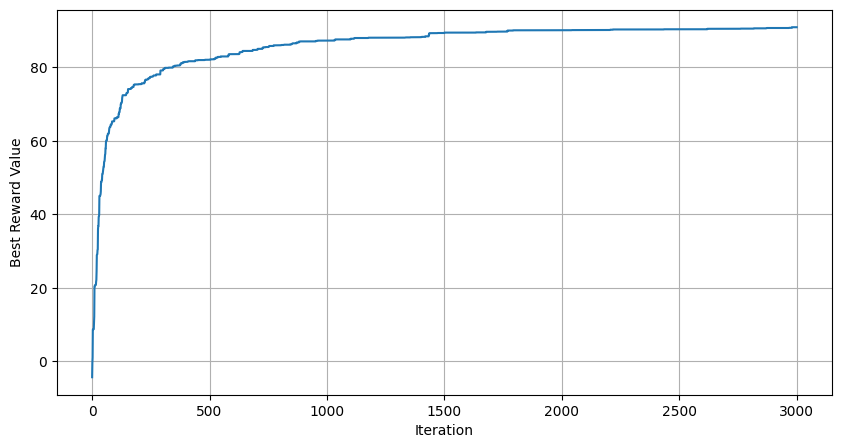

Total optimization time: 913.4991590976715 seconds


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from qpso import QDPSO
start_time = time.time()
# Create an instance of the environment
env = BatteryManagementEnv(alpha=1, beta=1, gamma=1, delta=1, epsilon=1)

# Constants
T = 48  # Time horizon

# Lists to capture actions and states for every time step
all_actions = []
all_states = []

# Modify the objective function
def f(x):
    cumulative_reward = 0
    env.reset()
    
    # Reshape and clip the action sequence according to the environment
    actions = x.reshape((T, env.action_space.shape[0]))
    actions = np.clip(actions, env.action_space.low, env.action_space.high)
    
    for t in range(T):
        obs, reward, done, truncated, info = env.step(actions[t])
       # reward = np.clip(reward, -1e, 1e1)
        cumulative_reward += reward
        if done:
            break
    
    # This is to gather actions for the last iteration
    if len(all_actions) < T:
        all_actions.extend(actions)
    
    return -cumulative_reward

# Define the number of particles, iterations, and dimensions
NParticle = 100
MaxIters = 3000
NDim = T * env.action_space.shape[0]

# Define the bounds for the optimization
low_bound = np.tile(env.action_space.low, T)
high_bound = np.tile(env.action_space.high, T)
bounds = list(zip(low_bound, high_bound))


# Quantum behavior parameter
g = 0.99

# Initialize the optimizer
optimizer = QDPSO(f, NParticle, NDim, bounds, MaxIters, g)

# Define a callback function for logging
rewards = []

def log(s):
    rewards.append(-s.gbest_value)
    if s.iters % 100 == 0:
        print("{0: >5}  {1: >9}  {2: >9}".format("Iters.", "Best Reward", "Best(Mean Reward)"))
        best_mean = np.mean([p.best_value for p in optimizer.particles()])
        print("{0: >5}  {1: >9.3E}  {2: >9.3E}".format(s.iters, -s.gbest_value, -best_mean))

# Perform optimization
optimizer.update(callback=log, interval=1)

# Plotting the convergence of rewards
plt.figure(figsize=(10,5))
plt.plot(rewards)
plt.xlabel("Iteration")
plt.ylabel("Best Reward Value")
#plt.title("Convergence of QDPSO's Best Reward")
plt.grid(True)

plt.savefig('ConvergenceofQDPSO.pdf', bbox_inches='tight', dpi=1200)
plt.show()

# Get the actions of the last iteration
best_actions_last_iter = all_actions[-T:]

# Record states and actions of the best solution from the last iteration
env.reset()
all_states_last_iter = []

#for action in best_actions_last_iter:
 #   if env.current_step >= T:  # Ensure we don't go beyond the time horizon
  #      break
   # obs, _, _, _ = env.step(action)
   # all_states_last_iter.append(obs)
    
end_time = time.time()
print(f"Total optimization time: {end_time - start_time} seconds")




In [ ]:
def evaluate(agent, num_timesteps=48):
    """
    Evaluate a trained agent.
    """
    env = BatteryManagementEnv(alpha=15, beta=3.85, gamma=1.91, delta=1.3, epsilon=0.134)
    state, _ = env.reset()
    state = np.array(state).reshape(1, -1)  # Ensure state is a 2D array
  


    battery_states = []
    power_battery_states = []
    grid_actions = []
    tariffs = []
    load_demands = []
    load_deferrals = []
    power_balances = []



    for _ in range(num_timesteps):
        action, _states = agent.predict(state, deterministic=True)
        action = action.flatten()  # Flatten the action array right after prediction

        B_action, P_B_action, grid_action, load_deferral = action

        state, _, _, _, _ = env.step(action)
        state_flat = np.array(state).flatten()

        battery_states.append(state_flat[0])
        power_battery_states.append(state_flat[1])
        tariffs.append(state_flat[3])
        load_demands.append(env.P_d[env.time_step-1])
        load_deferrals.append(load_deferral)  # capture load deferral

        # Calculate the power balance
        power_balance = env.P_d[env.time_step-1] - B_action - P_B_action - load_deferral*env.P_d[env.time_step-1] - grid_action 
        power_balances.append(power_balance)
        
        grid_actions.append(grid_action)

    return battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals, power_balances 

def plot_evaluation(battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals,power_balances):
    """
    Plot the evaluation results.
    """
    t = np.arange(48)
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(t, battery_states, label="Energy Battery State")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("State")
    plt.title("Energy Battery State over Time")

    plt.subplot(2, 3, 2)
    plt.plot(t, power_battery_states, label="Power Battery State")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("State")
    plt.title("Power Battery State over Time")

    plt.subplot(2, 3, 3)
    plt.plot(t, grid_actions, label="Grid Action")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Action")
    plt.title("Grid Action over Time")

    plt.subplot(2, 3, 4)
    plt.plot(t, tariffs, label="Tariff")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Tariff")
    plt.title("Grid Tariff over Time")

    plt.subplot(2, 3, 5)
    plt.plot(t, load_demands, label="Load Demand $P_d$")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Load Demand")
    plt.title("Load Demand over Time")

    #plt.subplot(2, 3, 6)
    #plt.plot(t, load_deferrals, label="Load Deferral")
    #plt.legend()
    #plt.xlabel("Time Step")
    #plt.ylabel("Deferral Amount")
    #plt.title("Load Deferral over Time")
    
    
    plt.subplot(2, 3, 6)
    plt.plot(t, load_deferrals, label="load deferrals")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Power (Normalized)")
    plt.title("Power Balance over Time")


    plt.tight_layout()
    plt.show()

# Assuming you've trained your SAC model and it's stored in the variable 'model'
battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals, power_balances = evaluate(agents['PPO'])
plot_evaluation(battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals, power_balances)


In [45]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
SEED = 0
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



class BatteryManagementEnv(gym.Env):
    def __init__(self, alpha, beta, gamma, delta, epsilon):
        self.T = 48  # Time horizon
        self.B_max = 2  # Max battery capacity
        self.B_min = 0  # Min battery capacity
        self.P_B_max = 1  # Max power battery capacity
        self.P_B_min = 0  # Min power battery capacity
        self.B_charge_rate = 0.1  # Rate of battery charge
        self.B_discharge_rate = -0.1  # Rate of battery discharge
        self.P_B_charge_rate = 0.2  # Rate of power battery charge
        self.P_B_discharge_rate = -0.2  # Rate of power battery discharge
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
                
        self.DoD_sequence = []
        self.P_DoD_sequence = []
        self.prev_soh = 1  # Initially, assume the battery is healthy
        self.prev_power_soh = 1  # Initially, assume the power battery is healthy
        self.charge_discharge_cycles = 0
        self.charge_discharge_cycles_1 = 0  # for the first battery type (DoD based)
        self.charge_discharge_cycles_2 = 0  # for the second battery type (P_DoD based)
    
        
        
        
        # Real load profiles and tariff prices
        self.P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])  # Load profile, shortened for brevity
        self.Cg_t = np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])  # Grid tariff prices, shortened for brevity
        self.P_d = (self.P_d - np.min(self.P_d)) / (np.max(self.P_d) - np.min(self.P_d))  # Normalize between 0 and 1
        self.Cg_t = (self.Cg_t - np.min(self.Cg_t)) / (np.max(self.Cg_t) - np.min(self.Cg_t))  # Normalize between 0 and 1

      

        # Action: [Battery charge/discharge, Power Battery charge/discharge, Grid power, Load deferral]
        self.action_space = spaces.Box(low=np.array([self.B_discharge_rate, self.P_B_discharge_rate, -1, 0]),
                                       high=np.array([self.B_charge_rate, self.P_B_charge_rate, 2, 1]),
                                       dtype=np.float32)

        # Observation: [Battery state, Power Battery state, Load, Grid Tariff]
        self.observation_space = spaces.Box(low=np.array([self.B_min, self.P_B_min, 0, 0]),
                                            high=np.array([self.B_max, self.P_B_max, 1, 1]),
                                            dtype=np.float32)

        self.state = None
        self.time_step = 0
        self.sigma_ref = 0.5
        self.k_sigma = 1.0
        self.soc_stress_history_1 = []
        self.soc_stress_history_2 = []

        
        
    def rainflow(self, sequence):
        reversed_sequence = sequence[::-1]
        cycles = []
        while len(reversed_sequence) > 2:
            if np.all((reversed_sequence[2] - reversed_sequence[1]) * (reversed_sequence[1] - reversed_sequence[0]) < 0):
                if  np.all(abs(reversed_sequence[1] - reversed_sequence[0])) <= np.all(abs(reversed_sequence[2] - reversed_sequence[1])):
                    half_cycle = (reversed_sequence.pop(1), reversed_sequence[0])
                    cycles.append(half_cycle)
                else:
                    reversed_sequence.pop(0)
            else:
                reversed_sequence.pop(0)
        return len(cycles)
    def compute_stress(self, sigma):
        """Compute the SoC stress based on the provided SoC.
        
        Args:
        - sigma (float): State of Charge (SoC) of the battery.
        
        Returns:
        - float: Computed SoC stress value.
        """
        S_sigma = np.exp(self.k_sigma * (sigma - self.sigma_ref))
        return S_sigma

    def calculate_fd(self, DoD_sequence):
        return self.charge_discharge_cycles  # Here fd is the count of charge/discharge cycles
    
    def calculate_fd_1(self):
        return self.charge_discharge_cycles_1
    
    def calculate_fd_2(self):
        return self.charge_discharge_cycles_2

    def compute_soh(self, fd):
        
        #solid electrolyte interphase
        alpha_sei = 0.0575  # Adjust as needed
        beta_sei = 121   # Adjust as needed
        L = 1 - alpha_sei *-beta_sei * fd - (1 - alpha_sei) * -fd
        return L
       
        
    


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)  # Set the random seed if provided

        self.time_step = 0

        # Random Gaussian values for each state component
        state_0 = np.clip(np.random.normal(1, 0.5), 0, 2)  # mean=1, std=0.5
        state_1 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_2 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_3 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        #state_4 = np.clip(np.random.normal(0, 0.5), -1, 1)  # mean=0, std=0.5

        self.state = [state_0, state_1, state_2, state_3]

        # Define any additional reset information you'd like to return.
        # Here we're using an empty dictionary, but you can populate it if needed.
        reset_info = {}

        return np.array(self.state), reset_info



    def step(self, action):
        B_action, P_B_action, grid_action, load_deferral = action

    # Calculate the required grid power based on the load and battery actions
     #   grid_action = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        # Ensure grid action is non-negative
      #  grid_action = max(0, grid_action)
    
            # Calculate the required grid power based on the load and battery actions
        #grid_power_required = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
            # Update the state based on the action

      
        grid_power_required = (self.P_d[self.time_step]) - (B_action + P_B_action) - (load_deferral*self.P_d[self.time_step]) -(grid_action)

        absolute_grid_power_required = np.abs(grid_power_required)
        
        #absolute_grid_power_required = np.clip(absolute_grid_power_required, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)
        
        grid_action = np.clip(grid_action, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)

        #Battery_power = B_action + P_B_action
        
       # if np.all(grid_action > absolute_grid_power_required):
          #     Battery_power = np.clip( B_action + P_B_action, grid_action - absolute_grid_power_required-0.0001,grid_action - absolute_grid_power_required + 0.0001)
        #else:  
        #    Battery_power = np.clip( B_action + P_B_action, absolute_grid_power_required - grid_action-0.0001, absolute_grid_power_required - grid_action + 0.0001)
        self.state[0] += B_action
        self.state[1] += P_B_action
        self.state[2] = self.P_d[self.time_step]*load_deferral
        self.state[3] = grid_power_required

    # Constraints
        self.state[0] = np.clip(self.state[0], self.B_min, self.B_max)
        self.state[1] = np.clip(self.state[1], self.P_B_min, self.P_B_max)
        

        self.time_step += 1
        done = self.time_step == self.T

    # Reward mechanism
        alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1  # Define appropriate values for these
            # Reward mechanism
    # Increase penalty for grid power by using a square term (or some other function)
        #emission_penalty = - ((grid_power_required)**2)
    
    # You can even consider having a term that penalizes significant deviation from the required grid power
        #imbalance_penalty = - abs(grid_action - grid_power_required) * 100 # This ensures power balance is maintained
        imbalance_penalty = - (((grid_action)) * self.Cg_t[self.time_step-1])*75
       # print(imbalance_penalty)
        battery_penalty = - (self.alpha*10 * max(0, 0.2 - self.state[0]) + self.beta *10 * max(0, self.state[0] - 1.8))
        power_battery_penalty = - (self.gamma * 10 * max(0, 0.2 - self.state[1]) + self.delta *10 * max(0, self.state[1] - 0.8))
        load_deferral_penalty = - self.epsilon * abs(load_deferral) * 10
        DoD = abs(self.state[0] - B_action)  # Assuming B_action is the change in the battery charge


       # print(f"Current SOH: {current_soh * 100:.2f}%")
        
        P_DoD = abs(self.state[1] - P_B_action)

            
           # Instead of appending every DoD to the sequence, only append if it's above a threshold
        DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(DoD) >= DoD_threshold):  # Increment the counter if DoD is beyond a threshold
            self.charge_discharge_cycles_1 += 1

    # Repeat for Power Battery
        P_DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(P_DoD) >= P_DoD_threshold):  # Increment the counter if P_DoD is beyond a threshold
            self.charge_discharge_cycles_2 += 1
            
            
            
        fd_1 = self.calculate_fd_1()
        current_soh = self.compute_soh(fd_1)
        fd_2 = self.calculate_fd_2()
        current_power_soh = self.compute_soh(fd_2)
        
        SoC_stress_1 = self.compute_stress(self.state[0]/2)
        
        SoC_stress_2 = self.compute_stress(self.state[1])

        




      
        health_penalty = - (1 - current_soh)  # Penalize based on the reduced SOH
        power_health_penalty = - (1 - current_power_soh)
        self.soc_stress_history_1.append(SoC_stress_1)
        self.soc_stress_history_2.append(SoC_stress_2)

        


        total_reward =  battery_penalty + power_battery_penalty +  SoC_stress_1 + SoC_stress_2 + imbalance_penalty + load_deferral_penalty 
       # Provide a reward if grid_power_required is between -2 and 0
        #emission_penalty  +
        if  grid_power_required <= 0:
            total_reward += 2
        if imbalance_penalty  >= 0 :
            total_reward += 20

            
        

        #print(f"emission:{emission_penalty}")
        #print(f"battery:{battery_penalty}")
        #print(f"power battery:{power_battery_penalty}")
        #print(f"SoC_stress_1:{SoC_stress_1}")
        #print(f"SoC_stress_2:{SoC_stress_2}")
        #print(f"imbalance_penalty:{imbalance_penalty}")
              
              
        
        
        #+ load_deferral_penalty 
        #+ imbalance_penalty
        #if imbalance_penalty >= 0:
         #   total_reward = total_reward+1000
        terminated = done  # This is the usual done flag
        truncated = False  # This is an additional flag. Set its value based on your requirements.
        info = {}  # Any additional information you want to provide.

        return self.state, total_reward, terminated, truncated, info


    def render(self, mode='human'):
        print(f"Time step: {self.time_step} | Energy Battery: {self.state[0]:.2f} | Power Battery: {self.state[1]:.2f} | Load: {self.state[2]:.2f} | Grid Tariff: {self.state[3]:.2f}")

    def close(self):
        pass

if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    

   # for _ in range(3):
        #state = env.reset()
       # done = False
       # while not done:
         #   action = env.action_space.sample()  # Take random actions
           # state, reward, terminated, truncated, info = env.step(action)
           # env.render()


Iteration 0: Best Reward: -2.738E+02, g: 0.990


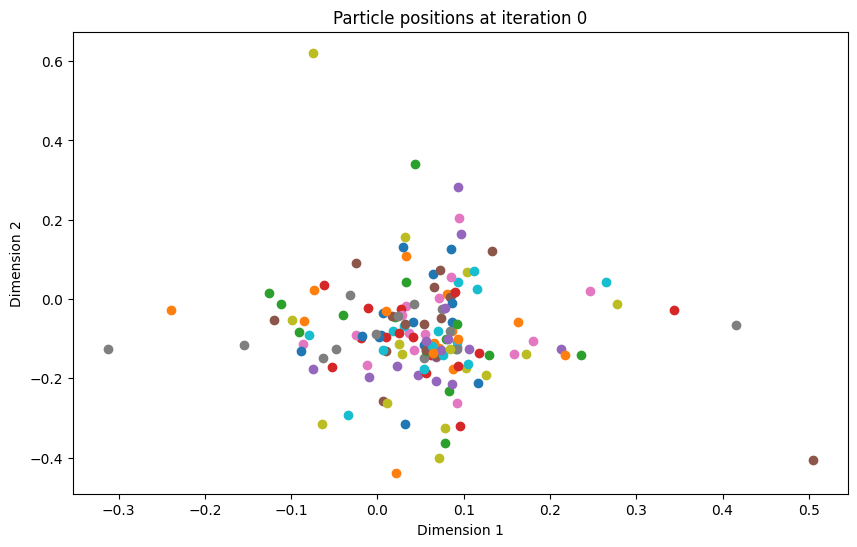

Iteration 100: Best Reward: 1.945E+01, g: 0.990


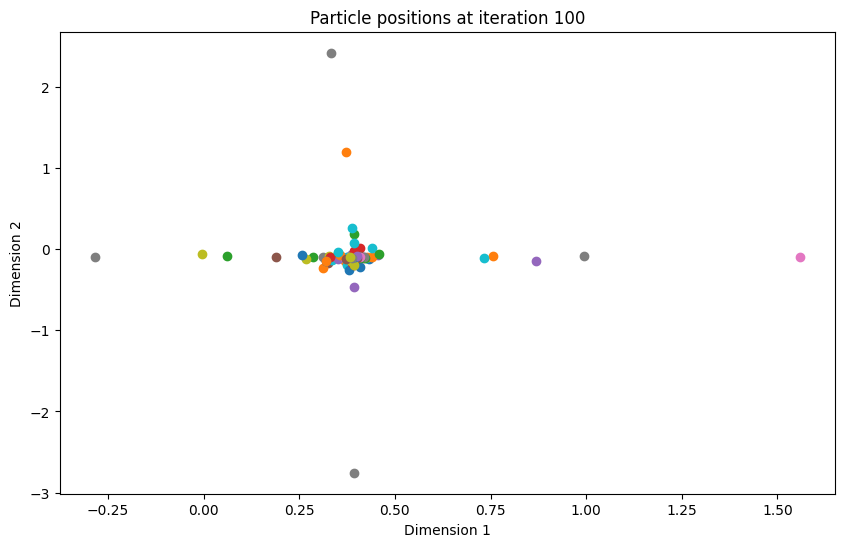

Iteration 200: Best Reward: 6.055E+01, g: 0.990


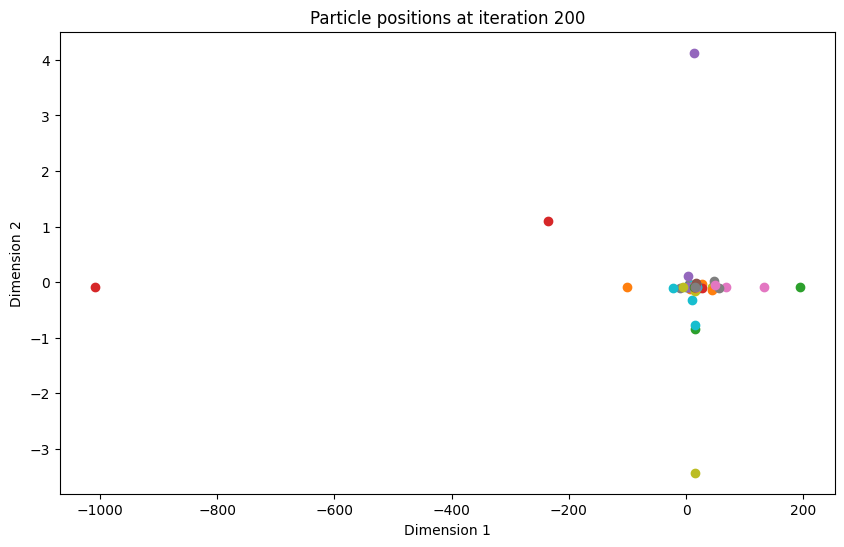

Iteration 300: Best Reward: 8.046E+01, g: 0.990


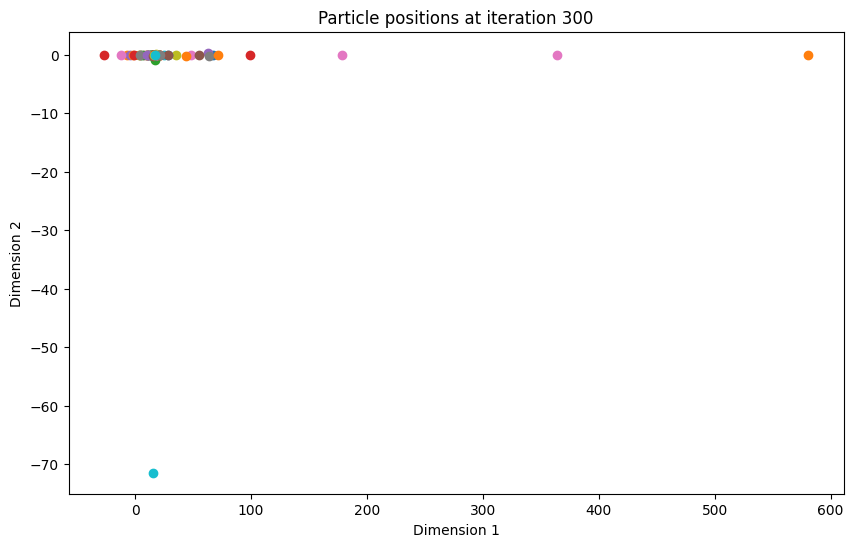

Iteration 400: Best Reward: 1.055E+02, g: 0.990


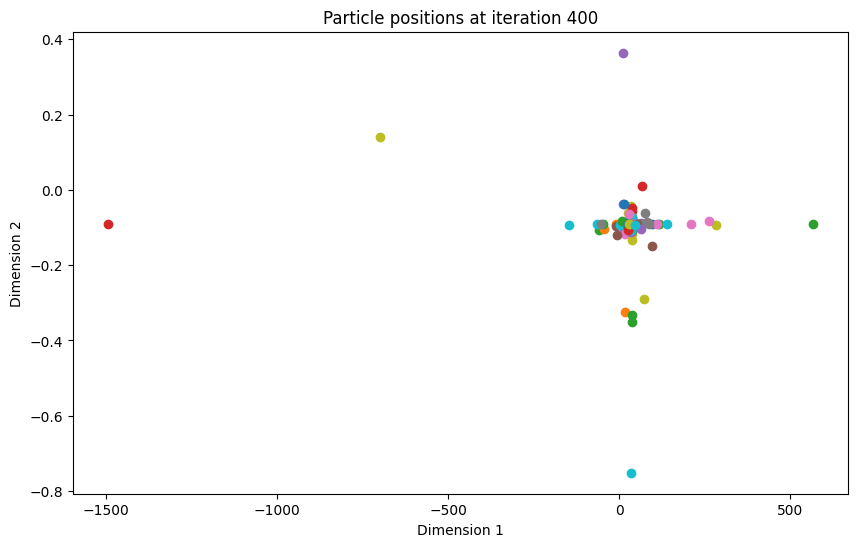

Iteration 500: Best Reward: 1.259E+02, g: 0.990


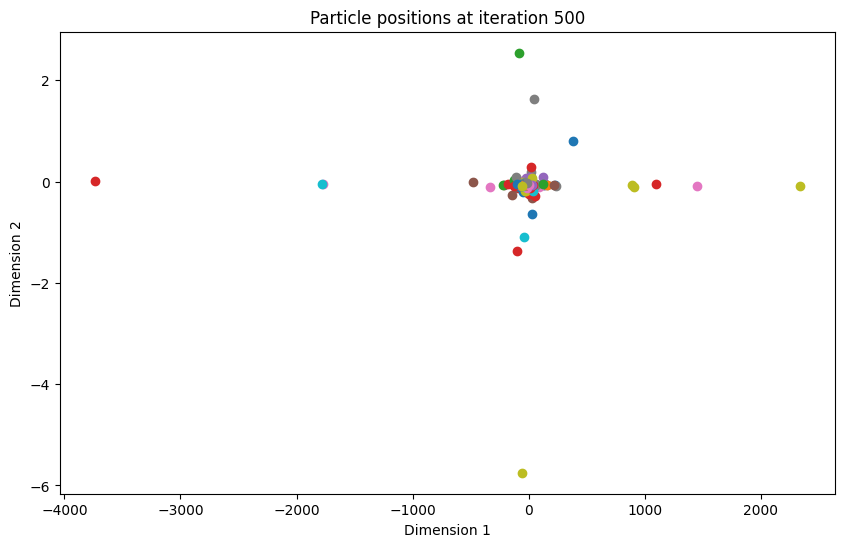

Iteration 600: Best Reward: 1.332E+02, g: 0.990


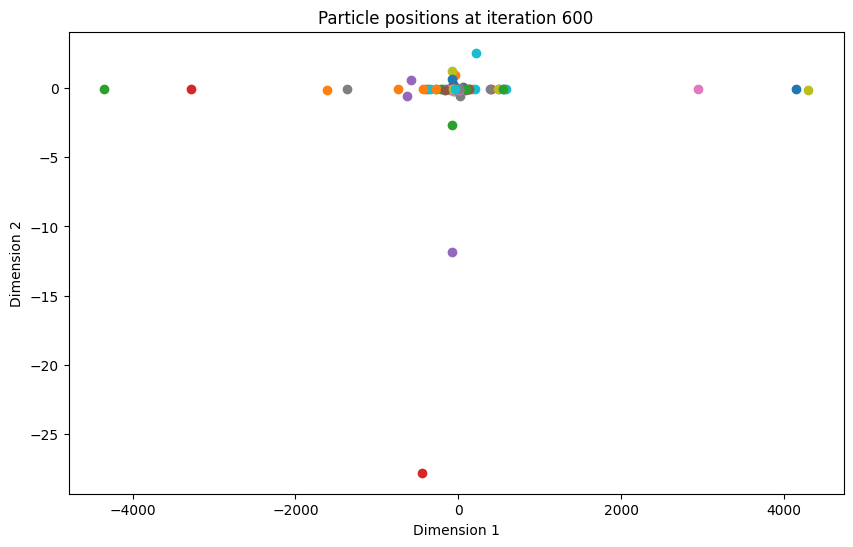

Iteration 700: Best Reward: 1.401E+02, g: 0.990


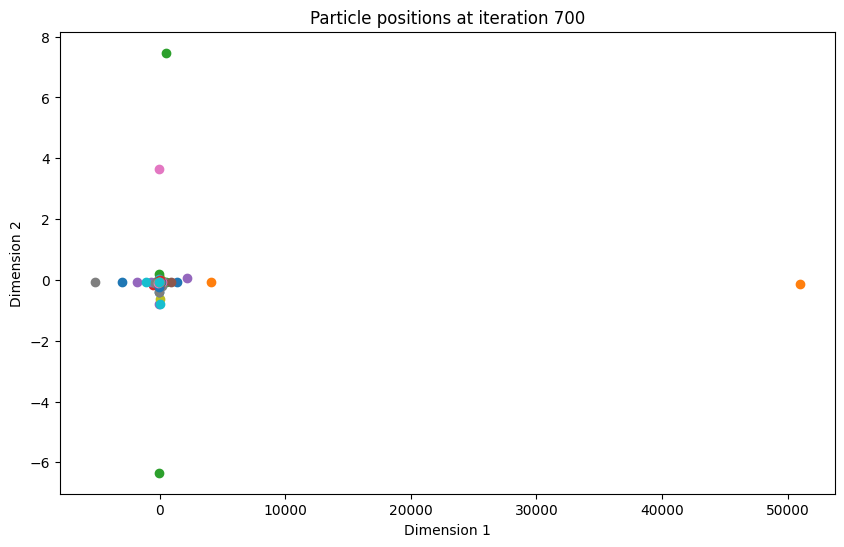

Iteration 800: Best Reward: 1.512E+02, g: 0.990


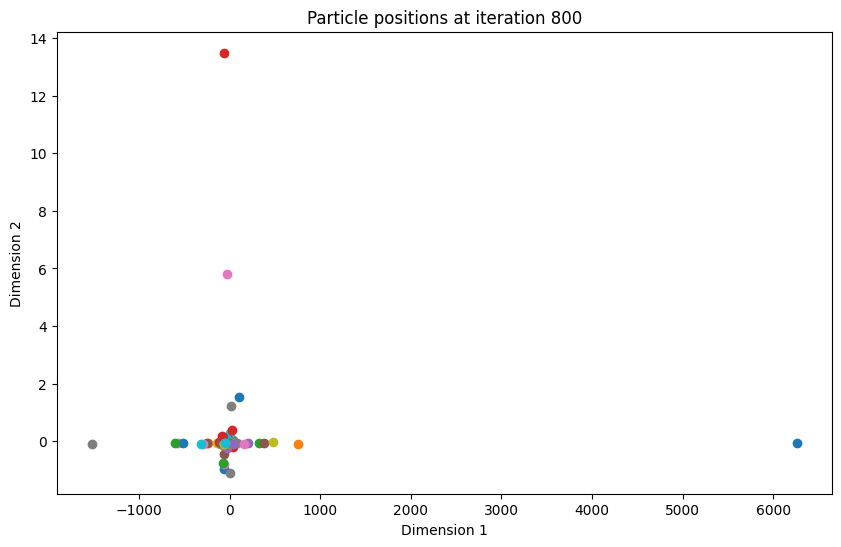

Iteration 900: Best Reward: 1.529E+02, g: 0.990


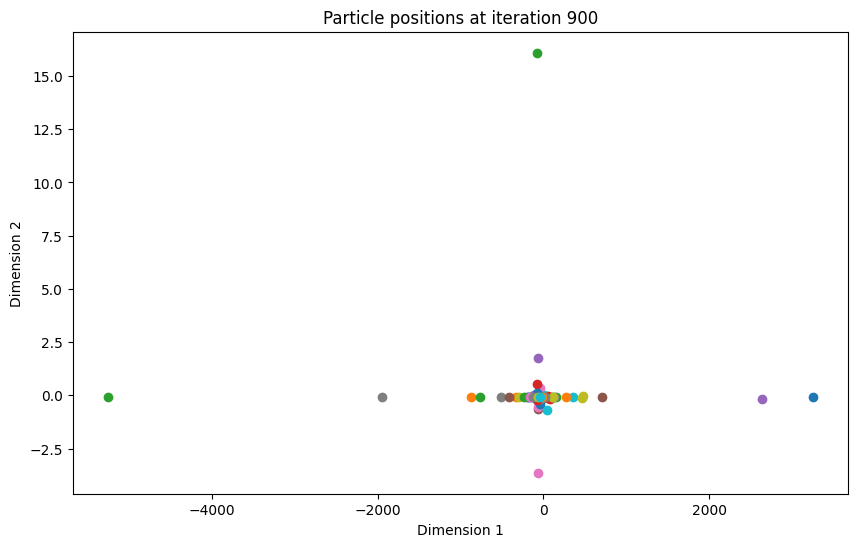

Iteration 1000: Best Reward: 1.546E+02, g: 0.990


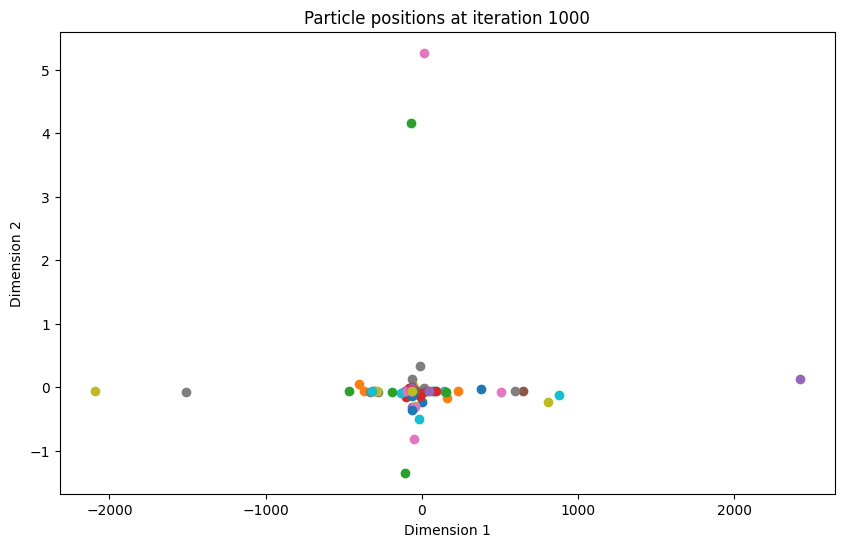

Iteration 1100: Best Reward: 1.612E+02, g: 0.990


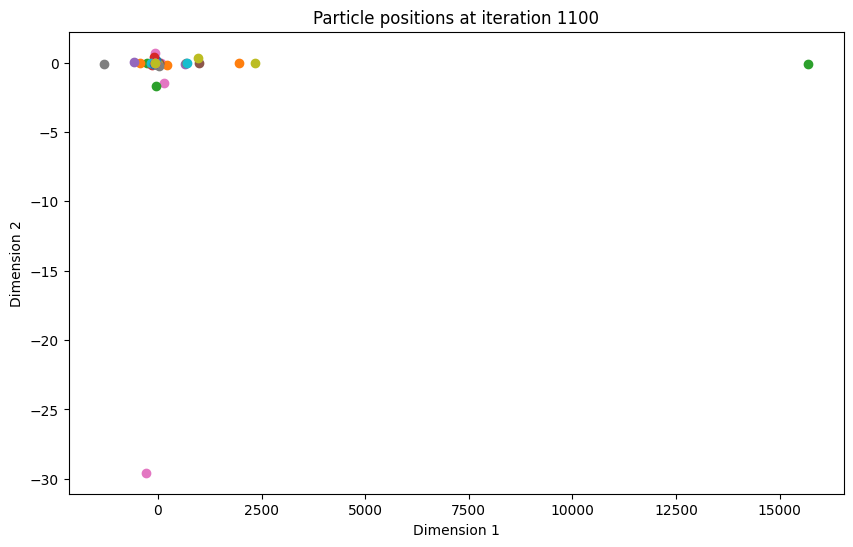

Iteration 1200: Best Reward: 1.669E+02, g: 0.990


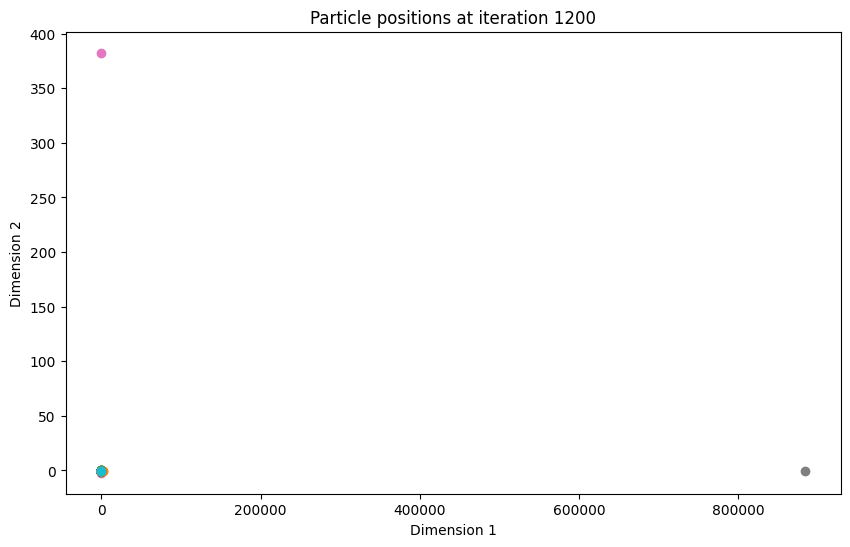

Iteration 1300: Best Reward: 1.877E+02, g: 0.990


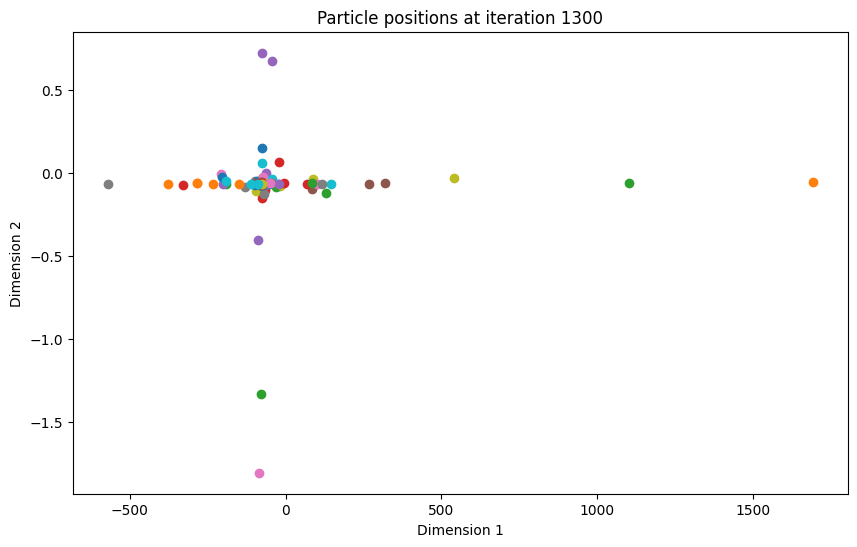

Iteration 1400: Best Reward: 1.901E+02, g: 0.990


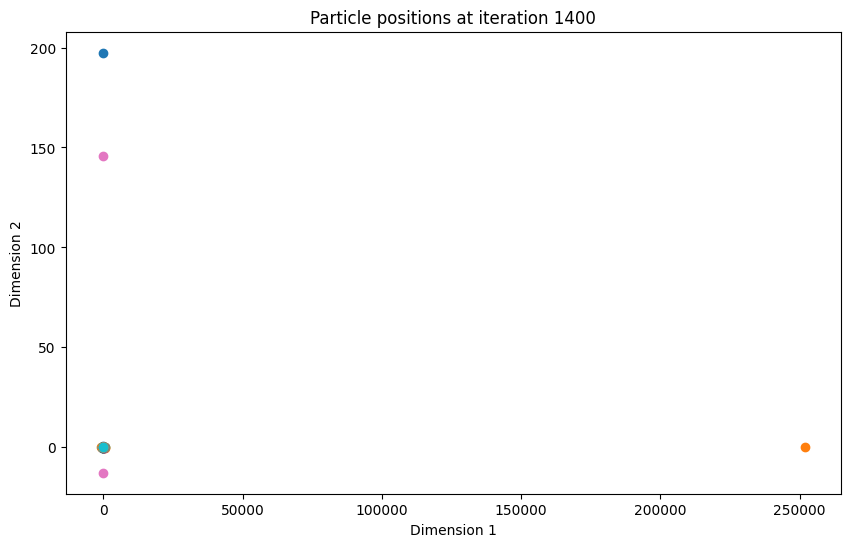

Iteration 1500: Best Reward: 1.937E+02, g: 0.990


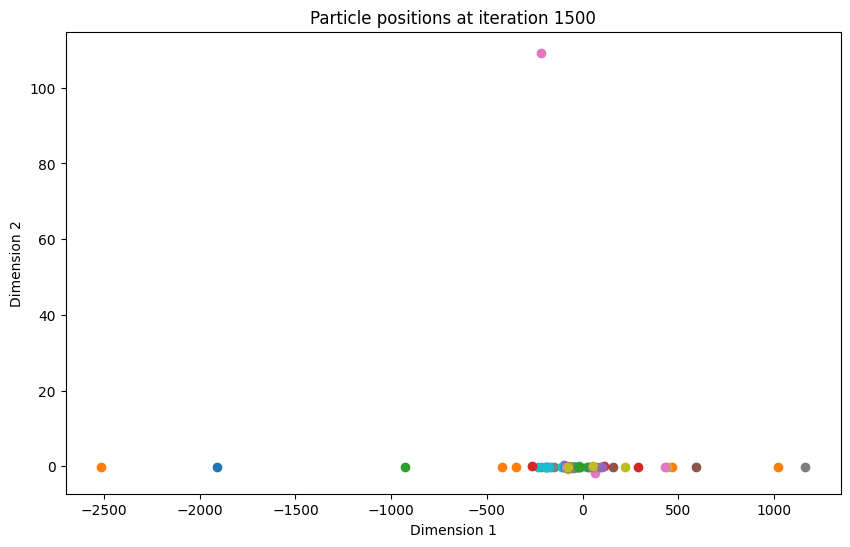

Iteration 1600: Best Reward: 2.016E+02, g: 0.990


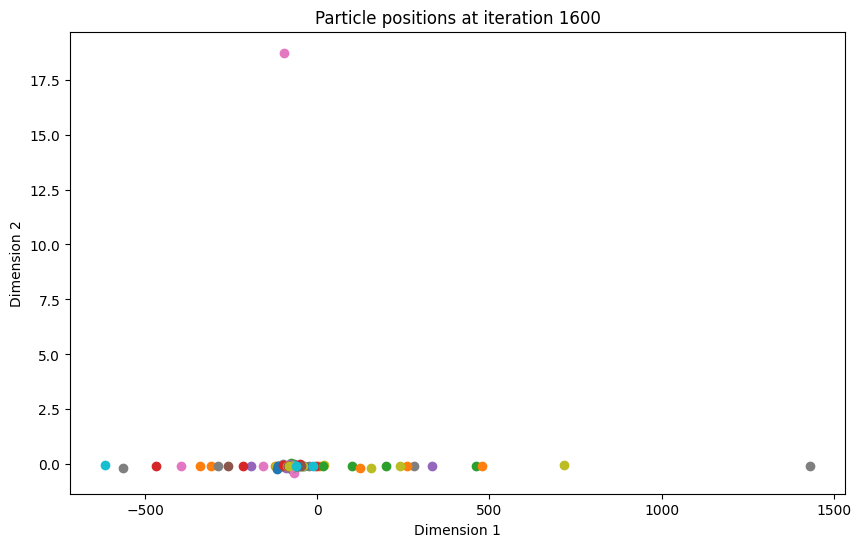

Iteration 1700: Best Reward: 2.024E+02, g: 0.990


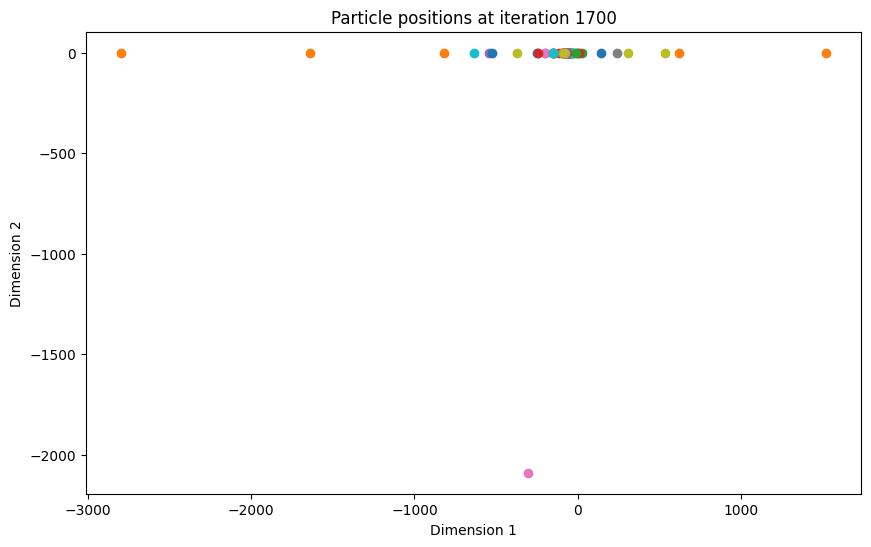

Iteration 1800: Best Reward: 2.049E+02, g: 0.990


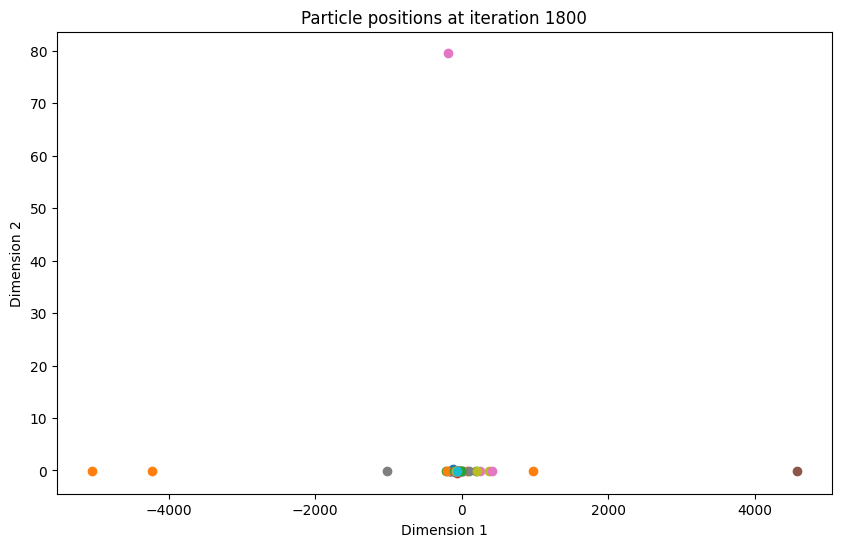

Iteration 1900: Best Reward: 2.072E+02, g: 0.990


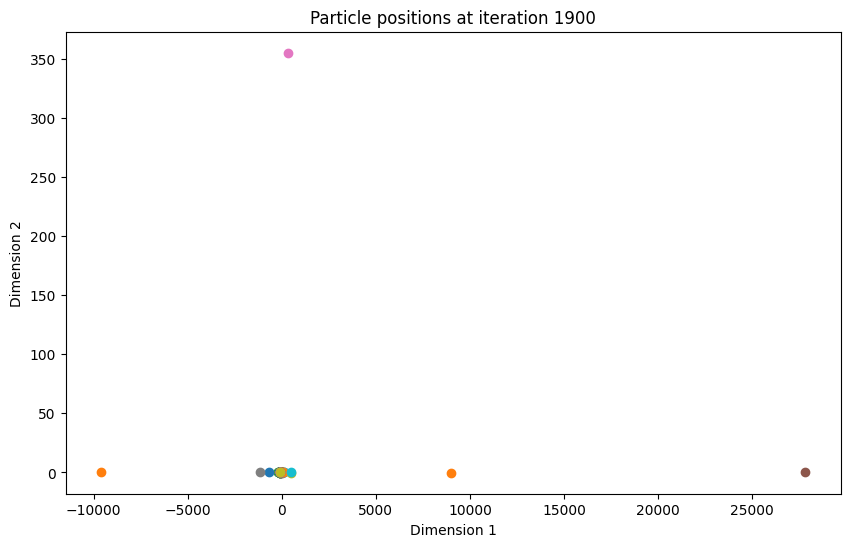

Iteration 2000: Best Reward: 2.077E+02, g: 0.990


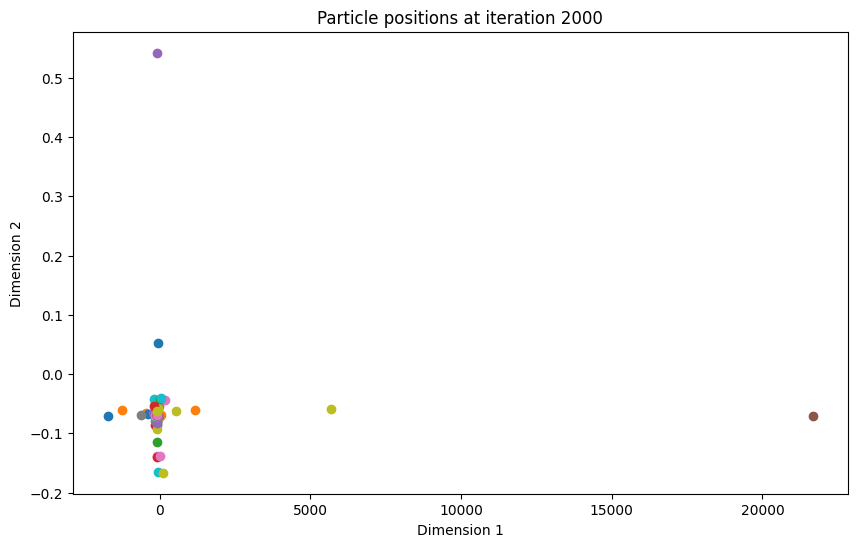

Iteration 2100: Best Reward: 2.090E+02, g: 0.990


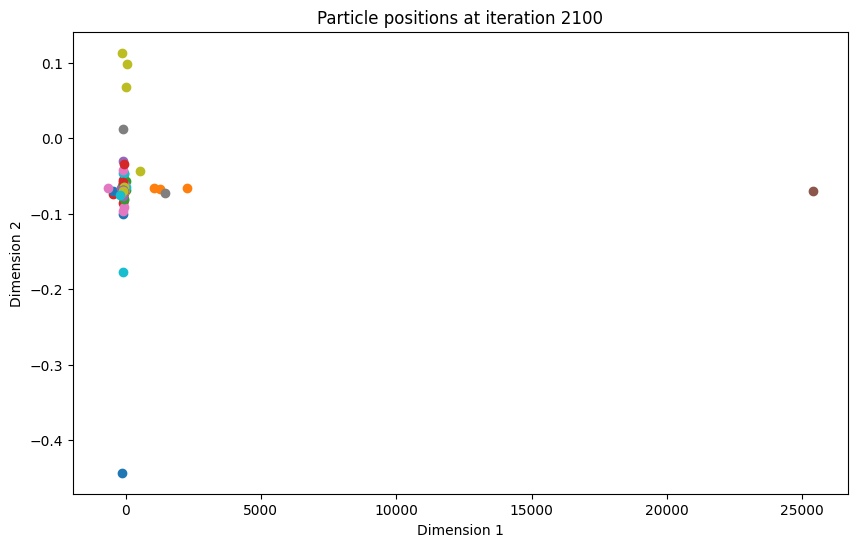

Iteration 2200: Best Reward: 2.090E+02, g: 0.990


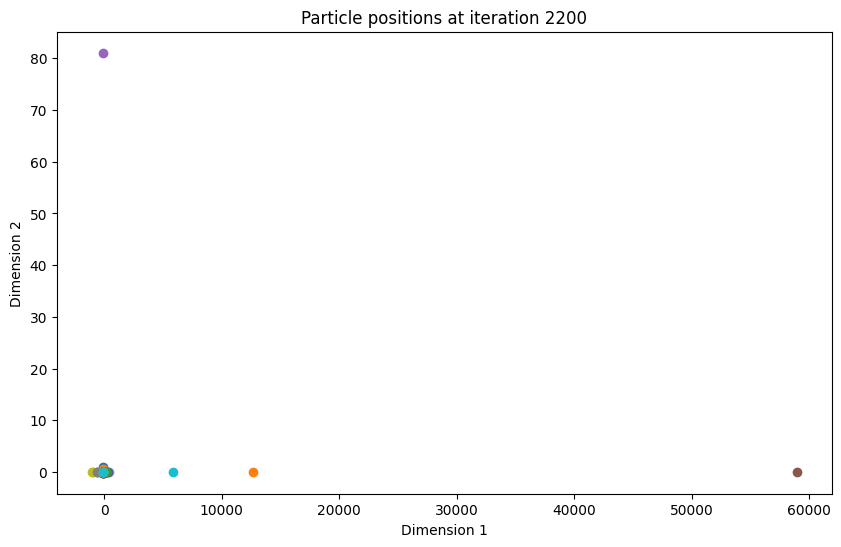

Iteration 2300: Best Reward: 2.090E+02, g: 0.990


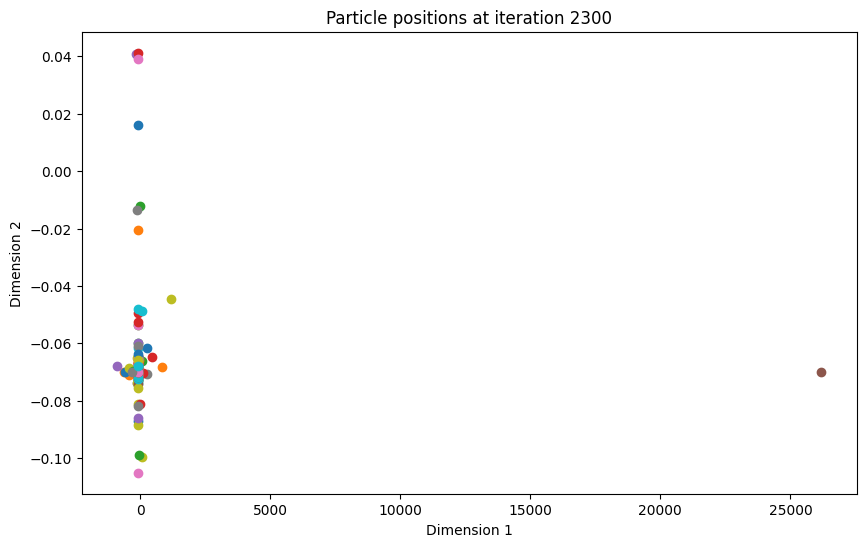

Iteration 2400: Best Reward: 2.090E+02, g: 0.990


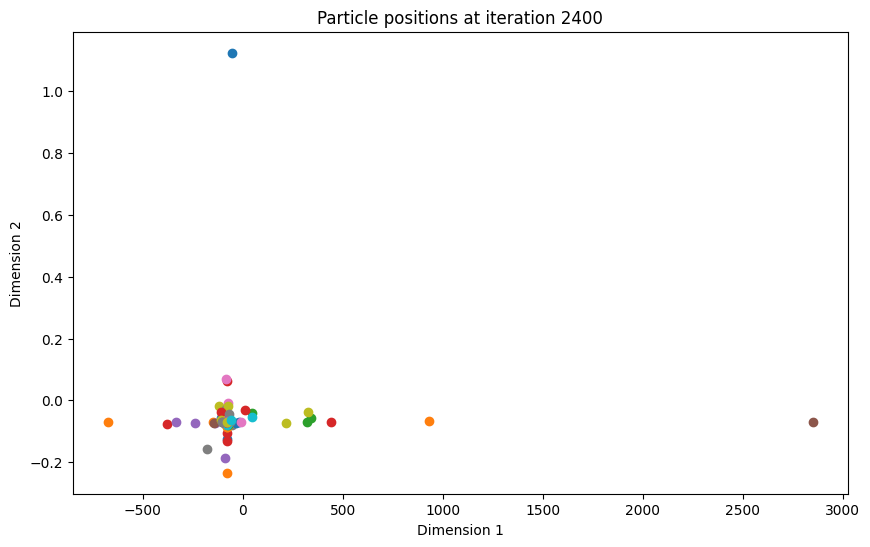

Iteration 2500: Best Reward: 2.122E+02, g: 0.990


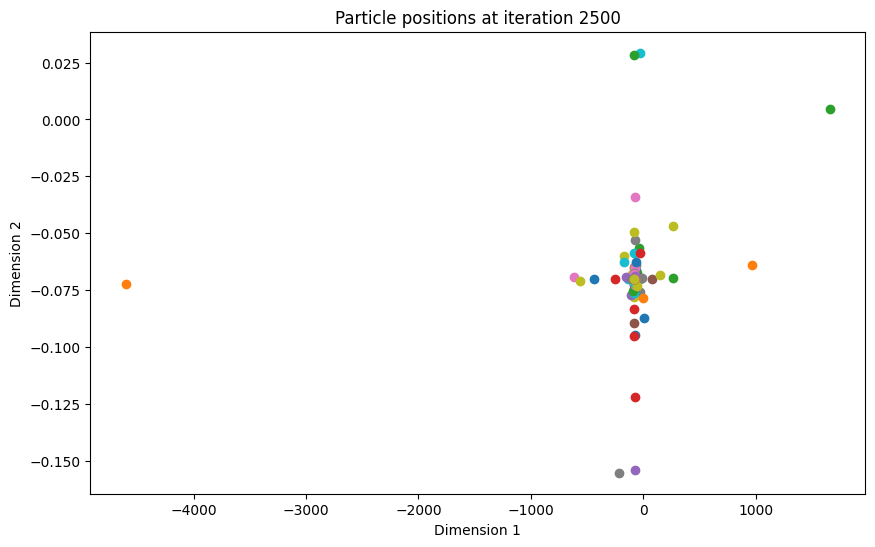

Iteration 2600: Best Reward: 2.122E+02, g: 0.990


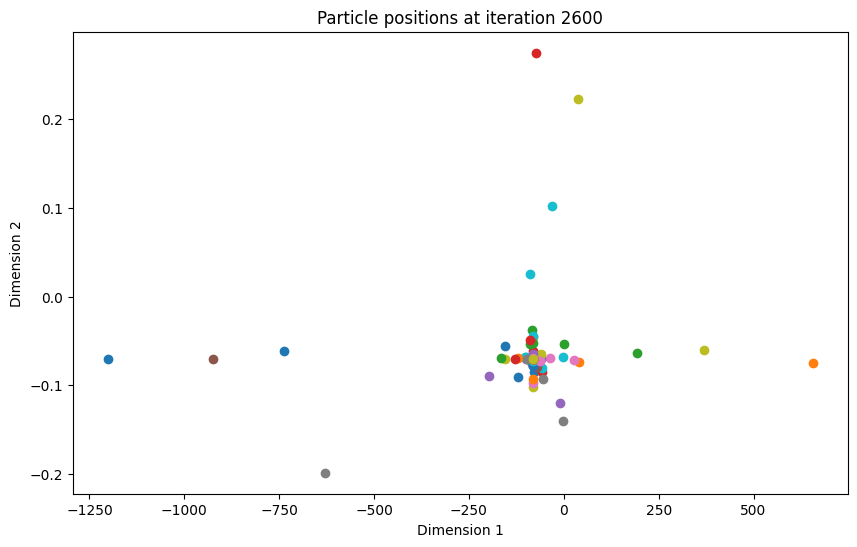

Iteration 2700: Best Reward: 2.126E+02, g: 0.990


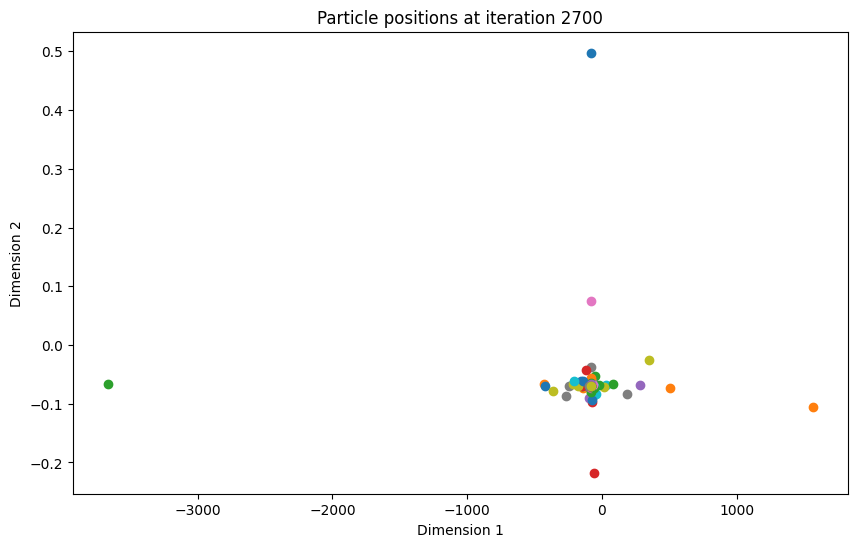

Iteration 2800: Best Reward: 2.128E+02, g: 0.990


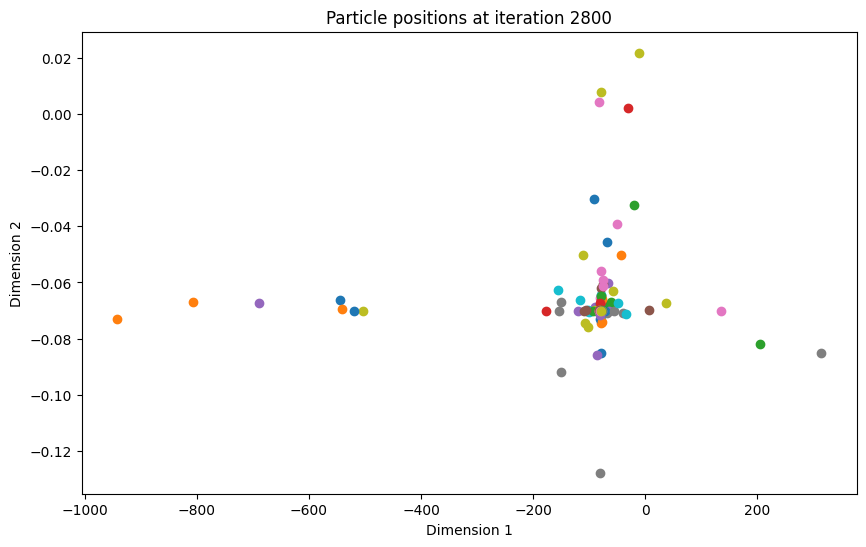

Iteration 2900: Best Reward: 2.128E+02, g: 0.990


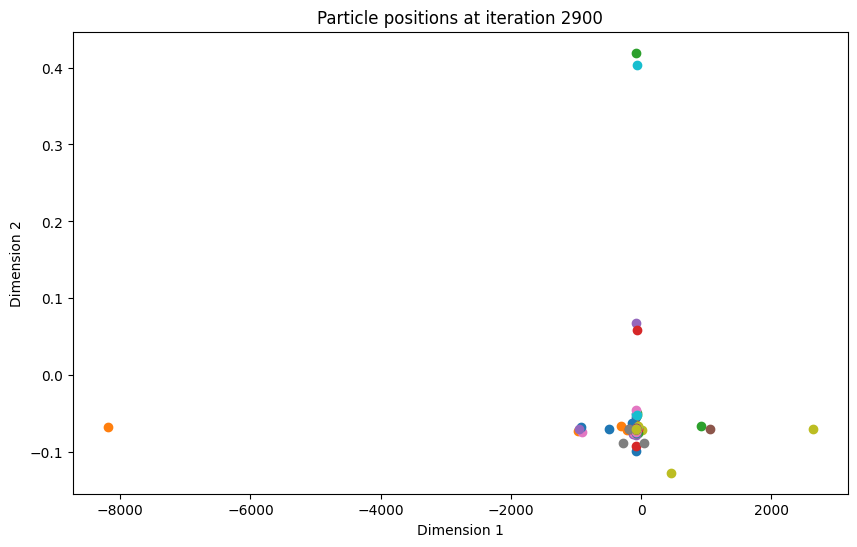

Iteration 3000: Best Reward: 2.128E+02, g: 0.990


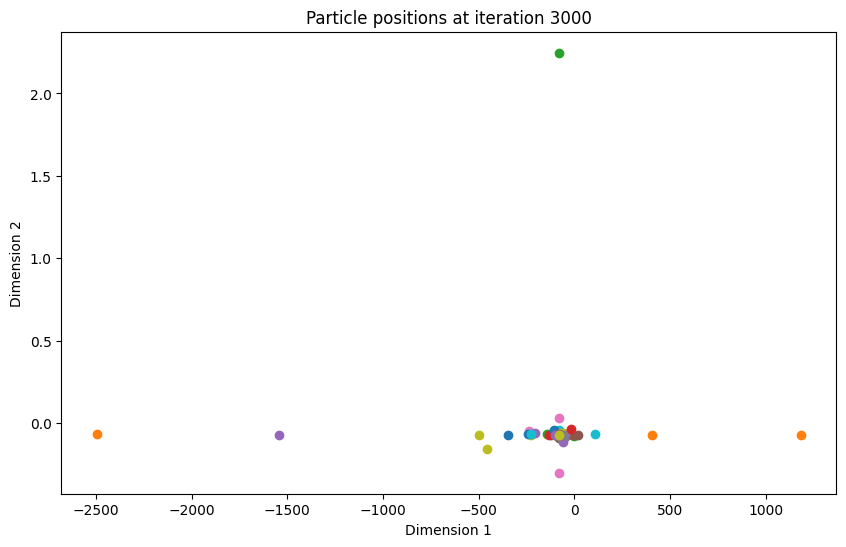

Total optimization time: 1601.6092586517334 seconds


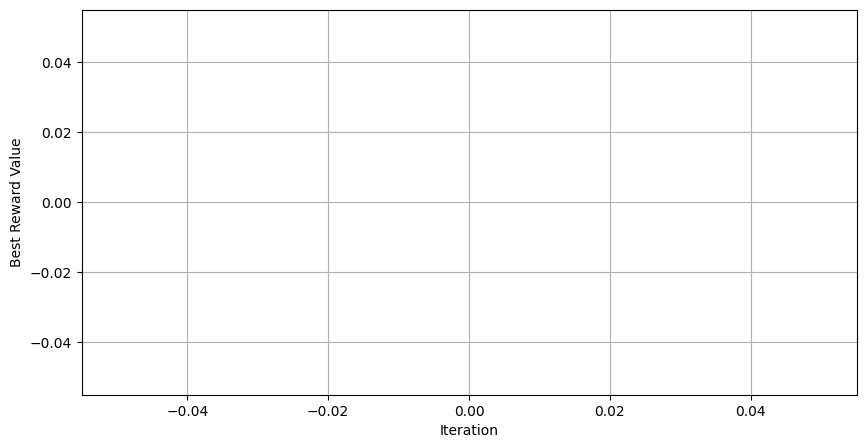

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import time
from qpso import QDPSO

# Initialize the environment
env = BatteryManagementEnv(alpha=1, beta=1, gamma=1, delta=1, epsilon=1)

# Constants
T = 48  # Time horizon

def objective_function(x):
    cumulative_reward = 0
    env.reset()
    actions = x.reshape((T, env.action_space.shape[0]))
    actions = np.clip(actions, env.action_space.low, env.action_space.high)
    for t in range(T):
        obs, reward, done, _, _ = env.step(actions[t])
        cumulative_reward += reward
        if done:
            break
    #print(f"Evaluating: {x[:5]}..., Reward: {cumulative_reward}")  # Debug print
    return -cumulative_reward
    
 

# Define the number of particles, iterations, and dimensions
n_particles = 150
max_iters = 3000
n_dim = T * env.action_space.shape[0]

# Define the bounds for the optimization
low_bound = np.tile(env.action_space.low, T)
high_bound = np.tile(env.action_space.high, T)
bounds = list(zip(low_bound, high_bound))

# Initialize the optimizer
g = 0.99
optimizer = QDPSO(objective_function, n_particles, n_dim, bounds, max_iters, g)

rewards = []

def log(s):
    #g = 0.99 - 0.98 * (s.iters / max_iters)
    #optimizer._g = g
    #rewards.append(-s.gbest_value)
    diversity = np.std([p.best_value for p in optimizer.particles()])
    avg_fitness = np.mean([p.best_value for p in optimizer.particles()])
    #print(f"Diversity: {diversity:.2E}, Average Fitness: {avg_fitness:.2E}")
    
    if s.iters % 100 == 0:
        print(f"Iteration {s.iters}: Best Reward: {-s.gbest_value:.3E}, g: {g:.3f}")
        
        # Visualize particle movements in 2D slice
        plt.figure(figsize=(10, 6))
        for p in optimizer.particles():
            plt.scatter(p[0], p[1])  # Only visualizing the first two dimensions as a slice
        plt.title(f'Particle positions at iteration {s.iters}')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()


# Perform optimization
start_time = time.time()
optimizer.update(callback=log, interval=1)
end_time = time.time()

print(f"Total optimization time: {end_time - start_time} seconds")

# Plotting the convergence of rewards
plt.figure(figsize=(10,5))
plt.plot(rewards)
plt.xlabel("Iteration")
plt.ylabel("Best Reward Value")
plt.grid(True)
plt.show()


Iters.  Best Reward  Best(Mean Reward)
    0  -2.597E+02  -4.054E+02
Iters.  Best Reward  Best(Mean Reward)
  100  6.110E+01  3.263E+00
Iters.  Best Reward  Best(Mean Reward)
  200  9.483E+01  3.455E+01
Iters.  Best Reward  Best(Mean Reward)
  300  1.184E+02  5.256E+01
Iters.  Best Reward  Best(Mean Reward)
  400  1.444E+02  6.929E+01
Iters.  Best Reward  Best(Mean Reward)
  500  1.531E+02  8.352E+01
Iters.  Best Reward  Best(Mean Reward)
  600  1.579E+02  9.642E+01
Iters.  Best Reward  Best(Mean Reward)
  700  1.607E+02  1.049E+02
Iters.  Best Reward  Best(Mean Reward)
  800  1.781E+02  1.107E+02
Iters.  Best Reward  Best(Mean Reward)
  900  1.855E+02  1.151E+02
Iters.  Best Reward  Best(Mean Reward)
 1000  2.071E+02  1.195E+02


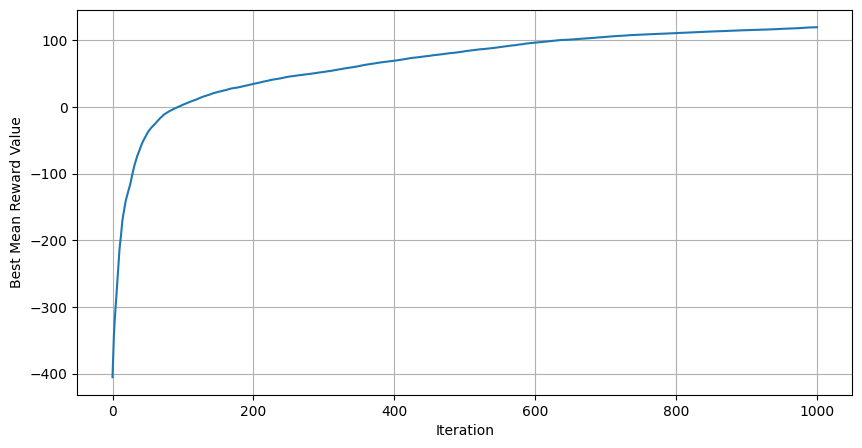

Total optimization time: 3480.8755836486816 seconds


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from qpso import QDPSO
start_time = time.time()
# Create an instance of the environment
env = BatteryManagementEnv(alpha=1, beta=1, gamma=1, delta=1, epsilon=1)

# Constants
T = 48  # Time horizon

# Lists to capture actions and states for every time step
all_actions = []
all_states = []

# Modify the objective function
def f(x):
    cumulative_reward = 0
    env.reset()
    
    # Reshape and clip the action sequence according to the environment
    actions = x.reshape((T, env.action_space.shape[0]))
    actions = np.clip(actions, env.action_space.low, env.action_space.high)
    
    for t in range(T):
        obs, total_reward, done, truncated, info = env.step(actions[t])
       # reward = np.clip(reward, -1e, 1e1)
        cumulative_reward += total_reward
        if done:
            break
    
    # This is to gather actions for the last iteration
    if len(all_actions) < T:
        all_actions.extend(actions)
    
    return -cumulative_reward

# Define the number of particles, iterations, and dimensions
NParticle = 1000
MaxIters = 1000
NDim = T * env.action_space.shape[0]

# Define the bounds for the optimization
low_bound = np.tile(env.action_space.low, T)
high_bound = np.tile(env.action_space.high, T)
bounds = list(zip(low_bound, high_bound))


# Quantum behavior parameter
g = 0.99

# Initialize the optimizer
optimizer = QDPSO(f, NParticle, NDim, bounds, MaxIters, g)

# Define a callback function for logging
# Define a callback function for logging
rewards = []
best_mean_rewards = []  # <-- New list to store best mean rewards

def log(s):
    rewards.append(-s.gbest_value)
    
    # Calculate the mean best reward of all particles and append it to best_mean_rewards
    best_mean = np.mean([-p.best_value for p in optimizer.particles()])
    best_mean_rewards.append(best_mean)
    
    if s.iters % 100 == 0:
        print("{0: >5}  {1: >9}  {2: >9}".format("Iters.", "Best Reward", "Best(Mean Reward)"))
        print("{0: >5}  {1: >9.3E}  {2: >9.3E}".format(s.iters, -s.gbest_value, best_mean))

# Perform optimization
optimizer.update(callback=log, interval=1)

# Plotting the convergence of best mean rewards
plt.figure(figsize=(10,5))
plt.plot(best_mean_rewards)  # <-- Plot best_mean_rewards instead of rewards
plt.xlabel("Iteration")
plt.ylabel("Best Mean Reward Value")
#plt.title("Convergence of QDPSO's Best Mean Reward")
plt.grid(True)

plt.savefig('ConvergenceofQDPSO_Mean.pdf', bbox_inches='tight', dpi=1200)
plt.show()

# Get the actions of the last iteration
best_actions_last_iter = all_actions[-T:]

# Record states and actions of the best solution from the last iteration
env.reset()
all_states_last_iter = []

#for action in best_actions_last_iter:
 #   if env.current_step >= T:  # Ensure we don't go beyond the time horizon
  #      break
   # obs, _, _, _ = env.step(action)
   # all_states_last_iter.append(obs)
    
end_time = time.time()
print(f"Total optimization time: {end_time - start_time} seconds")




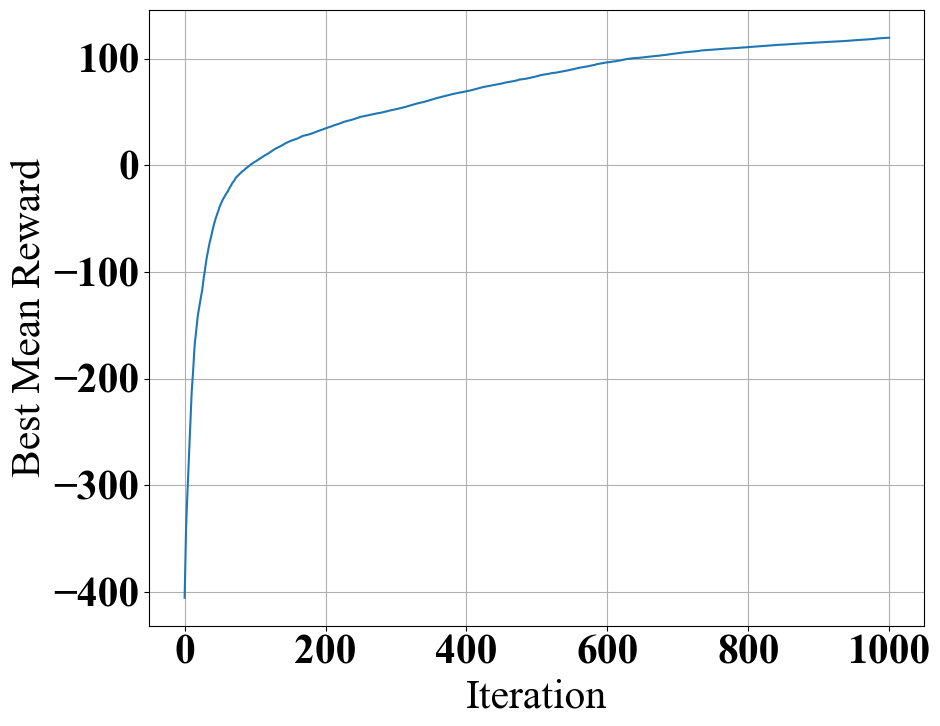

In [61]:
import matplotlib.pyplot as plt

# Define the font properties
font = {'family': 'Times New Roman',
        'weight': 'bold',
        'size': 30}

# Apply the font settings
plt.rc('font', **font)


# Plotting the convergence of best mean rewards
plt.figure(figsize=(10,8))
plt.plot(best_mean_rewards)  # <-- Plot best_mean_rewards instead of rewards
plt.xlabel("Iteration")
plt.ylabel("Best Mean Reward")
plt.grid(True)

# Save the figure
plt.savefig('ConvergenceofQDPSO_Mean.pdf')
plt.show()
